In [ ]:
# This notebook illustrates handling the August 2024 Demo of the 12mo Evaluation Scenario 1

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd

RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-08", "12_month_scenario_1", "q1a_ii")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_base_request.json"
)


request_params = {}

# %load_ext autoreload
# %autoreload 2

In [ ]:
H_odeint = [0.0,
 0.07584066320978722,
 0.14636646265873351,
 0.21517239301596403,
 0.2849940641423008,
 0.35803162126534144,
 0.43617188357763786,
 0.5211433080571843,
 0.6146269952842578,
 0.7183393339849907,
 0.8340968480485813,
 0.9638704485112929,
 1.1098340730821774,
 1.2744112432601529,
 1.460322143778306,
 1.6706331916641786,
 1.9088107460125325,
 2.178780372444439,
 2.4849930017839568,
 2.832499327828298,
 3.227033820607022,
 3.6751098523322363,
 4.184127609093503,
 4.762496481974214,
 5.419774326784966,
 6.166825487583933,
 7.016000445528594,
 7.981340143729251,
 9.078808185052266,
 10.326554856871647,
 11.745217338261286,
 13.358261021733336,
 15.192367626771185,
 17.277876514948733,
 19.64928647253589,
 22.345826309466535,
 25.41210364728401,
 28.898842636443945,
 32.863722838161294,
 37.37233298620304,
 42.49925554848381,
 48.32929991918692,
 54.95890451703756,
 62.49773100251825,
 71.07047694046699,
 80.81893664895041,
 91.9043442331066,
 104.51003757795193,
 118.84448659151495,
 135.14473616311494,
 153.6803198995054,
 174.75770892931388,
 198.7253686880845,
 225.9795066077193,
 256.9706043940812,
 292.2108414225009,
 332.28253040812973,
 377.8477020062484,
 429.65899353366785,
 488.57201806502917,
 555.5594130725682,
 631.7267930288757,
 718.33086148102,
 816.7999711100919,
 928.7574539225811,
 1056.0480899336421,
 1200.768126390387,
 1365.2993106701535,
 1552.3474521757955,
 1764.986108867584,
 2006.7060366726942,
 2281.4711317587603,
 2593.781675837228,
 2948.74577656625,
 3352.159985334878,
 3810.6001762079927,
 4331.523867699931,
 4923.385255496248,
 5595.764320925713,
 6359.511470886844,
 7226.909216017238,
 8211.852427514215,
 9330.048735030014,
 10599.240502623044,
 12039.44975726627,
 13673.24714065712,
 15526.045525426567,
 17626.41847934686,
 20006.442805113635,
 22702.063309712732,
 25753.476547071572,
 29205.528188227865,
 33108.11624152888,
 37516.58927032621,
 42492.12476694649,
 48102.06815038656,
 54420.207487559084,
 61526.95241138342,
 69509.3788326499,
 78461.09204661413,
 88481.85690086993,
 99676.93033933835,
 112156.03116953523,
 126031.8764591974,
 141418.21409965339,
 158427.29086936626,
 177166.7077374985,
 197735.64179407313,
 220220.4490700916,
 244689.7128999469,
 271188.8609711989,
 299734.54505555454,
 330309.0420578748,
 362855.0097454492,
 397270.9706782105,
 433407.9323314221,
 471067.5318962573,
 510002.05000426056,
 549916.5325942405,
 590473.1326448151,
 631297.6155083764,
 671987.805397328,
 712123.5855505902,
 751277.9419388921,
 789028.4531510238,
 824968.6089066564,
 858718.3673693967,
 889933.4450316473,
 918312.9510473183,
 943605.1145011623,
 965610.9989351172,
 984186.2260247911,
 999240.8449867101,
 1010737.5652130407,
 1018688.6250969241,
 1023151.5961628385,
 1024224.424518873,
 1022039.9954607659,
 1016760.4778537896,
 1008571.6676818144,
 997677.5091145145,
 984294.9309318912,
 968649.0965921708,
 950969.132919035,
 931484.3726190757,
 910421.1206448845,
 887999.9365984657,
 864433.4099252748,
 839924.3952308263,
 814664.6678259049,
 788833.956208313,
 762599.306145181,
 736114.7329186859,
 709521.118576635,
 682946.3131058007,
 656505.4041417397,
 630301.1204001798,
 604424.3395841966,
 578954.674586528,
 553961.1153107659,
 529502.705890681,
 505629.24208586576,
 482381.97446456744,
 459794.3062235543,
 437892.47709088976,
 416696.2258780569,
 396219.4261885734,
 376470.6921664646,
 357453.95052101125,
 339168.9775714914,
 321611.9004232435,
 304775.66215856594,
 288650.4511800376,
 273224.0956361533,
 258482.42403353218,
 244409.59338260329,
 230988.3864887854,
 218200.48005631237,
 206026.6853722251,
 194447.16337089916,
 183441.61586876688,
 172989.45475247476,
 163069.95085616622,
 153662.36416343783,
 144746.05696746017,
 136300.5914987689,
 128305.81345597992,
 120741.9227885983,
 113589.53299236886,
 106829.72009170499,
 100444.06240763294,
 94414.6720882853,
 88724.21934978342,
 83355.95026825309,
 78293.69889597349,
 73521.89440676449,
 69025.56391080657,
 64790.33151791613,
 60802.414180610635,
 57048.61477377206]

import matplotlib.pyplot as plt
plt.plot(H_odeint)


In [ ]:
# Constants for the scenario
STATES = ["S", "I", "E", "R", "H", "D"]
# IDART = ["Diagnosed", "Infected", "Ailing", "Recognized",  "Threatened"]

MAX_TIME=150
STEP_SIZE=5
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

In [ ]:
# Helper functions to setup FUNMAN for different steps of the scenario

def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False, dreal_precision=1e-1):
    # Overrides for configuration
    #
    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    # funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = dreal_precision
    # funman_request.config.verbosity = 10
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False):
    to_synthesize = get_synthesized_vars(funman_request)
    return Runner().run(
        MODEL_PATH,
        funman_request,
        description="SIERHD Eval 12mo Scenario 1 q1",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )

def setup_common(funman_request, synthesize=False, debug=False, dreal_precision=1e-1):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug, dreal_precision=dreal_precision)
    

def set_compartment_bounds(funman_request, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=STATES, additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        # pd.options.plotting.backend = "plotly"
        ax = df[STATES].plot()
        
    
        fig = plt.figure()
        # fig.set_yscale("log")
        fig.savefig("save_file_name.pdf")
        plt.close()

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name):
    plot_last_point(results)
    param_values = get_last_point_parameters(results)
    # print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    pretty_print_request_params(request_params)

def add_unit_test(funman_request):
    pass
    # funman_request.constraints.append(LinearConstraint(name="unit_test", variables = [
    #         "Infected",
    #         "Diagnosed",
    #         "Ailing",
    #         "Recognized",
    #         "Threatened"
    #      ],
    #      additive_bounds= {
    #         "lb": 0.55,
    #         "ub": 0.65
    #      },
    #      timepoints={
    #         "lb": 45,
    #         "ub": 55
    #      }
    #   ))


In [ ]:
# i) (TA1 Search and Discovery Workflow, 1 Hr. Time Limit) Find estimates on the
# efficacy of surgical masks in preventing onward transmission of SARS-CoV-2 (preferred)
# or comparable viral respiratory pathogens (e.g., MERS-CoV, SARS), including any
# information about uncertainty in these estimates. The term surgical mask here refers to
# the commonly available, disposable procedure mask, not an N95-type respirator. Find 3
# credible documents that provide estimates and use your judgment to determine what
# value (in the deterministic case) or distribution (in the probabilistic case) to use in your
# forecasts in 1.a.iii.

# The base model assumes no masking inverventions, and we measure the efficacy in terms of the number of hospitalized.

funman_request = get_request()
setup_common(funman_request, debug=True, dreal_precision=1e-3)
add_unit_test(funman_request)
results = run(funman_request)
report(results, "unconstrained")
pass
# pts = results.parameter_space.points() 
# print(f"{len(pts)} points")
# df = results.dataframe(points=pts[-1:])
# df

In [ ]:
results
# get_last_point_parameters(results)
# plot_last_point(results)
# def plot_last_point(results):
#     pts = results.parameter_space.points() 
#     print(f"{len(pts)} points")

#     if len(pts) > 0:
#         # Get a plot for last point
#         df = results.dataframe(points=pts[-1:])
#         ax = df[STATES].plot()
#         ax.set_yscale("log")
pts = results.parameter_space.points() 
print(f"{len(pts)} points")
df = results.dataframe(points=pts[-1:])

df['H_odeint'] = pd.Series(H_odeint[0:151])
df["H_diff"] = df.H - df.H_odeint
df[["H", "H_odeint", "H_diff"]]
# df.H[100.0:150.0]
# results.parameter_space.points()[0].values

In [ ]:
# df.columns
# import matplotlib.pyplot as plt
# plt.plot(H_odeint)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"a": [0, 1], "b": [3, 4]})
l = list(df.a.values)
# l = [float(v) for v in l]
type(l[0])

# p = plt.plot(df.a, df.b)
df
# print(p)
# plt.plot(l)

# plt.plot(df.a.values)
# plt.plot(df['a'])
# df.plot()

In [ ]:
# Add bounds [0, N] to the STATE compartments.  
# Add bounds sum(STATE) in [N-e, N+e], for a small e.

funman_request = get_request()
setup_common(funman_request, debug=True)
set_compartment_bounds(funman_request)
results = run(funman_request)
report(results, "compartmental_constrained")

In [ ]:
# Relax the bounds on the parameters to allow additional parameterizations

funman_request = get_request()
setup_common(funman_request)
set_compartment_bounds(funman_request)
relax_parameter_bounds(funman_request, factor = 0.75)
results = run(funman_request)
report(results, "relaxed_bounds")

In [ ]:
funman_request = get_request()
setup_common(funman_request, synthesize=True)
set_compartment_bounds(funman_request)
# relax_parameter_bounds(funman_request, factor=0.75)
# funman_request.config.verbosity=10
results = run(funman_request, plot=True)
report(results, "synthesis")

In [ ]:
# import pandas as pd
# df1 = pd.DataFrame({"ltp": ltp, "gtp": gtp})

# # df2 = 
# # df1.ltp.N == df1.gtp.N
# # df2.loc[df2].sort_index()[0:60]

# #(= H_10 (+ H_8 (* 2 (+ (* r_HD (- 1) H_8) (* r_HR (- 1) H_8) (* r_IH_v I_v_8) (* r_IH_u I_u_8)))))

# df1['same'] = df1['ltp'] == df1["gtp"]
# df1[0:20]
# # df1.loc[df1.index.str.endswith("_6")].sort_values(by="same")

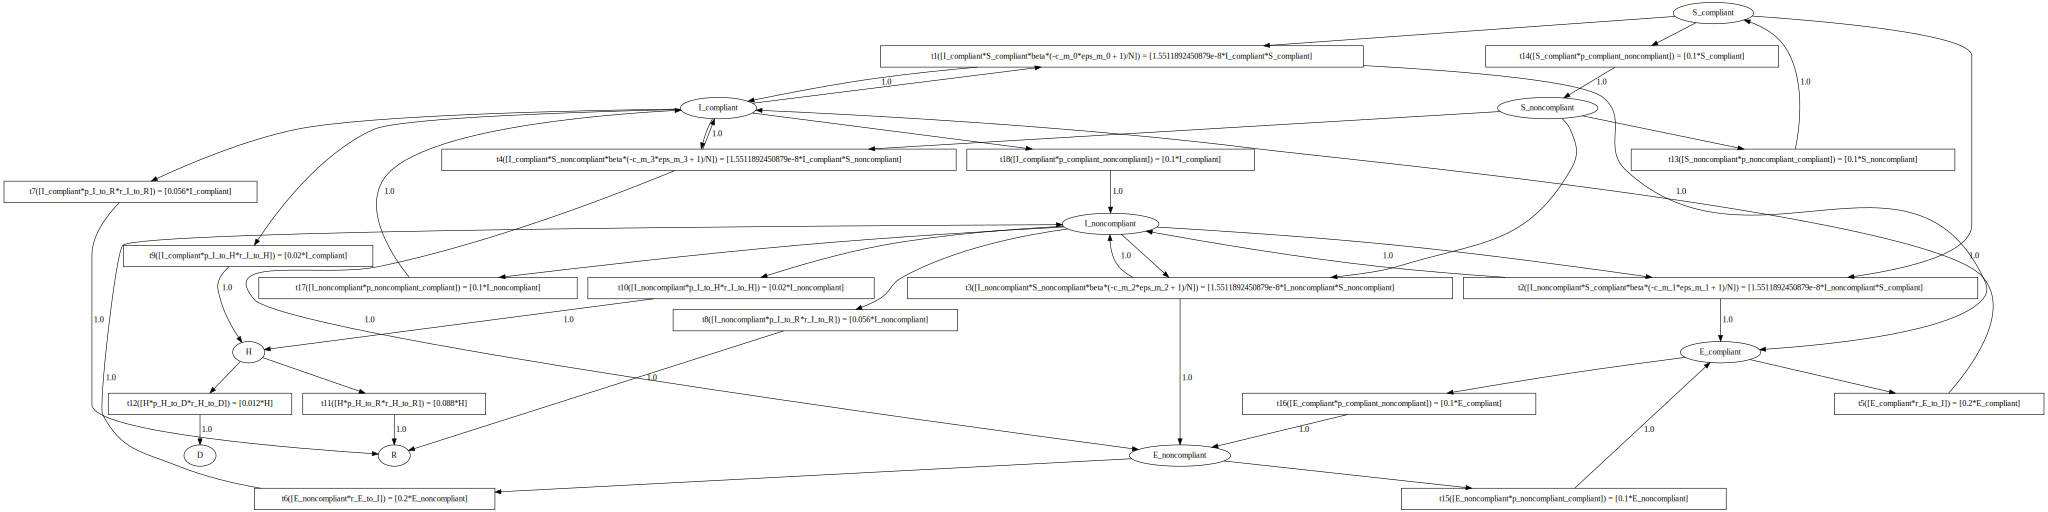

In [9]:
# # Get points (trajectories generated)
# pts = results.parameter_space.points() 
# print(f"{len(pts)} points")

# # Get a plot for last point
# df = results.dataframe(points=pts[-1:])
# ax = df[STATES].plot()
# ax.set_yscale("log")


# # Get the values of the point
# gtp=pts[-1].values


# # Output the model diagram
# #
results.model.to_dot()
# # gtp